In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.preprocessing import image



from keras.initializers import glorot_uniform


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """ 
    An identity block.

    Parameters
    ----------
    input_tensor:

    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer seed here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation, when addition
    # is performed on convolutional layers, the element-wise addition is performed
    # on their feature maps, i.e. channel by channel
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x
# generate some fake data to work with
np.random.seed(0)
X = np.random.randn(3, 4, 4, 6)
print('original data shape:', X.shape)
  

stage = 1
block = 'a'
inputs = layers.Input(shape=X.shape[1:])

outputs = identity_block(inputs, kernel_size=2, filters=[2, 4, 6], stage=stage, block=block)

model = Model(inputs=inputs, outputs=outputs)
prediction = model.predict(X)
print('identity block output shape:', prediction.shape)
prediction[1, 1, 0]





def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """ 
    A block that has a conv layer at shortcut.

    Parameters
    ----------
    input_tensor:
    
    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.
        
    strides : tuple, default (2, 2)
        Strides for the first conv layer in the block.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format,
    # which is the case if we are using the default
    # keras' backend tensorflow
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer set here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=strides,
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # we resize the input so its dimension will match the output dimension
    # of the main path
    shortcut = layers.Conv2D(filters3, kernel_size=(1, 1), strides=strides,
                             kernel_initializer=glorot_uniform(seed=0),
                             padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut) 

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x



stage = 1
block = 'a'
inputs = layers.Input(shape=X.shape[1:])

outputs = conv_block(inputs, kernel_size=2, filters=[2, 4, 6], stage=stage, block=block)

model = Model(inputs=inputs, outputs=outputs)
prediction = model.predict(X)
print('identity block output shape:', prediction.shape)
prediction[1, 1, 0]



from keras.datasets import mnist
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0] , 'test samples')


n_classes = 10
img_rows, img_cols = 28, 28

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = img_rows, img_cols, 1

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255
print('train shape:', X_train.shape)

# one-hot encode the class (target) vectors
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)
print('y_train shape:', Y_train.shape)


def ResNet(input_shape, n_classes):

    img_input = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    # x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)

    model = Model(inputs=img_input, outputs=img_output, name='resnet')
    return model


model = ResNet(input_shape, n_classes)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Using TensorFlow backend.


original data shape: (3, 4, 4, 6)
identity block output shape: (3, 4, 4, 6)
identity block output shape: (3, 2, 2, 6)
11493376/11490434 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 34, 34, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        conv1_pad[0][

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 19s 352us/step - loss: 0.1612 - accuracy: 0.9487 - val_loss: 0.4688 - val_accuracy: 0.8480
Epoch 2/10
54000/54000 [==============================] - 13s 238us/step - loss: 0.0468 - accuracy: 0.9849 - val_loss: 0.0628 - val_accuracy: 0.9812
Epoch 3/10
54000/54000 [==============================] - 13s 238us/step - loss: 0.0308 - accuracy: 0.9896 - val_loss: 0.1290 - val_accuracy: 0.9660
Epoch 4/10
54000/54000 [==============================] - 13s 239us/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0683 - val_accuracy: 0.9818
Epoch 5/10
54000/54000 [==============================] - 13s 238us/step - loss: 0.0216 - accuracy: 0.9930 - val_loss: 0.0458 - val_accuracy: 0.9882
Epoch 6/10
54000/54000 [==============================] - 13s 237us/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0632 - val_accuracy: 0.9853
Epoch 7/10
54000/54000 [==============================] -

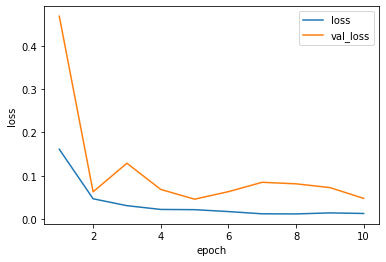

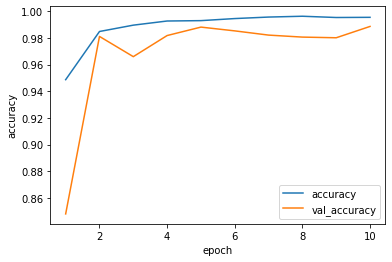

In [3]:

history = model.fit(X_train, Y_train,validation_split=.1, epochs=10, batch_size=256)

loss, accuracy = model.evaluate(X_test, Y_test)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))



a = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', a[0])
print('Test accuracy:', a[1])




loss= history.history['loss']
valloss= history.history['val_loss']
acc= history.history['accuracy']
valacc= history.history['val_accuracy']
epochs=10
plt.plot(np.linspace(1,epochs,epochs),loss,label="loss")
plt.plot(np.linspace(1,epochs,epochs),valloss,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(np.linspace(1,epochs,epochs),acc,label="accuracy")
plt.plot(np.linspace(1,epochs,epochs),valacc,label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()



# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.title('Loss')
# plt.xlabel('epoch')
# plt.ylabel("loss")
# plt.legend()
# plt.show()



# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
# plt.title('Accuracy')
# plt.xlabel('epoch')
# plt.ylabel("accuracy")
# plt.legend()
# plt.show()